2013-01-02
2013-01-03
2013-01-04
2013-01-05
2013-01-06
2013-01-07
2013-01-08
2013-01-09
2013-01-10
2013-01-11
2013-01-12
2013-01-13
2013-01-14
2013-01-15
2013-01-16
2013-01-17
2013-01-18
2013-01-19
2013-01-20
2013-01-21
2013-01-22
2013-01-23
2013-01-24
2013-01-25
2013-01-26
2013-01-27
2013-01-28
2013-01-29
2013-01-30
2013-01-31
2013-02-01
2013-02-02
2013-02-03
2013-02-04
2013-02-05
2013-02-06
2013-02-07
2013-02-08
2013-02-09
2013-02-10
2013-02-11
2013-02-12
2013-02-13
2013-02-14
2013-02-15
2013-02-16
2013-02-17
2013-02-18
2013-02-19
2013-02-20
2013-02-21
2013-02-22
2013-02-23
2013-02-24
2013-02-25
2013-02-26
2013-02-27
2013-02-28
2013-03-01
2013-03-02
2013-03-03
2013-03-04
2013-03-05
2013-03-06
2013-03-07
2013-03-08
2013-03-09
2013-03-10
2013-03-11
2013-03-12
2013-03-13
2013-03-14
2013-03-15
2013-03-16
2013-03-17
2013-03-18
2013-03-19
2013-03-20
2013-03-21
2013-03-22
2013-03-23
2013-03-24
2013-03-25
2013-03-26
2013-03-27
2013-03-28
2013-03-29
2013-03-30
2013-03-31
2013-04-01
2013-04-02

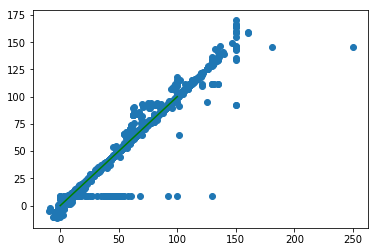

MAPE: inf %


In [32]:
# -*- coding: utf-8 -*-


import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

tick_name="hour_utc"

def perdelta(start, end, delta):
    """ Iterator (used for listing date values within a range)
    @param start first value (in our case, a datetime.date value)
    @param end last value (in our case, a datetime.date value)
    @param delta step size (in our case, a datetime.timedelta value)
    """
    curr = start
    while curr < end:
        yield curr
        curr += delta

def prediction_modelbuilder(data_all, train_end_date,model):
    """ Build a model with data before the given data
    @param data_all input dataframe
    @param train_end_date end date
    @param model to fit the dataset
    """   
        
    # create train/test split based on data availability
    train = data_all[data_all['date'] < str(train_end_date)]
    
    train = train.dropna()
    
    # every dataframe variable not in this list will be used as input features for training
    # (note that the target variable also goes here)
    non_input_features = ['date', 'target']
    
    # build model
    model = model.fit(train.drop(non_input_features, axis=1), train['target'])
        
    return model

def rolling_prediction_scheme(data_all, from_date, to_date, retrain_how_often_days,progressbar=True):
    """
    Framework for evaluating daily predictions over a time period with GBM model
    @param data_all input dataframe
    @param from_date starting date
    @param to_date ending date
    @param retrain_how_often_days model training will happen on from_date
        and subsequently every <retrain_how_often_days>-th day
    """
    model = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=5, \
                                      subsample=0.8, min_samples_leaf=10, learning_rate=0.1, \
                                      random_state=2013, verbose = 0)
    
    return rolling_prediction_scheme_with_model(data_all, from_date, to_date, retrain_how_often_days, \
                                                model,progressbar)

def rolling_prediction_scheme_with_model(data_all, from_date, to_date, retrain_how_often_days, \
                                         model,progressbar=True):
    """
    Framework for evaluating daily predictions over a time period with a given model
    @param data_all input dataframe
    @param from_date starting date
    @param to_date ending date
    @param retrain_how_often_days model training will happen on from_date
        and subsequently every <retrain_how_often_days>-th day
    @param regression machine learning model to predict the dataset
    """   
    #all_available_dates will cover the days of the evaluation period
    all_available_dates = []
    for available_date in perdelta(from_date, to_date, timedelta(days=1)):
        all_available_dates.append(available_date)
        
    #print(all_available_dates)    
    
    # retrain list with length equal to all_available_dates
    retrain_flags = []
    for i in range(0, len(all_available_dates)):
        if i % retrain_how_often_days == 0:
            retrain_flags.append(True)
        else:
            retrain_flags.append(False)

    #print(retrain_flags)
            
    # we collect results in this list
    collected_preds = []

    # iterate over all_available_dates
    for available_date, retrain_flag in zip(all_available_dates, retrain_flags):
        
        # one-day-ahead prediction
        target_date = available_date + timedelta(days = 1)
        if progressbar==True:
            print(target_date)
        
        #print(all_available_dates)
        # create train/test split based on data availability
        train = data_all[data_all['date'] <= str(available_date)].copy()
        test = data_all[data_all['date'] == str(target_date)].copy()
        
        #print(test)
        train = train.dropna()
        #print(train)
        
        # every dataframe variable not in this list will be used as input features for training
        # (note that the target variable also goes here)
        non_input_features = ['date', 'target']
        
        #print(train.drop(non_input_features, axis=1))
        
        # build model
        if retrain_flag is True:
            model = model.fit(train.drop(non_input_features, axis=1), train['target'])
        
        # get predictions
        test['prediction'] = model.predict(test.drop(non_input_features, axis=1))
        
        #print(test)
        
        # add predictions of this iteration to collected results
        collected_preds.append(test[['date',tick_name, 'target', 'prediction']])

    # we make a dataframe from the collected results
    collected_preds = pd.concat(collected_preds)
        
    return collected_preds



def mape(actual, predicted):
    """calculate mean absolute percentage error (MAPE)
    @param actual vector of actual target values
    @param predicted vector of predicted target values
    """
    return np.mean(np.abs((actual - predicted) / actual)) * 100



if __name__ == "__main__":
    
    odata = pd.read_csv( 'HUPX.csv')

    calendar = pd.read_csv('calendar.csv')
    data = odata.merge(calendar, on = 'date', how = 'inner')

    #Krisz:
    data['target'] = data['price'].copy()
    
    #Kerdes: erre mert van szukseg?
    #for x in [24,48,96,168]:
    #    data["Lag"+str(x)]=data['target'].shift(x)   
    #print(data)
    
    # do rolling evaluation on 2016
    preds = rolling_prediction_scheme(data, \
                                      from_date = date(2013, 1, 1),\
                                      to_date = date(2014, 12, 30), \
                                      retrain_how_often_days = 3)
    
    #scatterplot
    plt.scatter(preds['target'],preds['prediction'])
    plt.plot([0,100],[0,100],color="green")
    plt.show()
    
    '''
    #UjResz
    feltetel= preds["date"]=="2016-01-09"   
    p2=preds[feltetel]
    plt.plot(p2['target'],color="blue")
    plt.ylim(0,60)
    plt.plot(p2["prediction"],color="orange")
    '''
    print('MAPE: {} %'.format(mape(preds['target'], preds['prediction'])))

    